# UPRM Hackathon 2024 - Text Classification with Neural Networks

## Importing Necessary Libraries 

In [1]:
!pip3 install -r requirements.txt

  Using cached accelerate-0.34.2-py3-none-any.whl.metadata (19 kB)
Using cached accelerate-0.34.2-py3-none-any.whl (324 kB)


## Training

In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, confusion_matrix
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os
model_name = "allenai/scibert_scivocab_uncased"
checkpoints_folder = ""
output_dir = './scibert3'
# Load the pretrained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

# Define Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Preprocessing function for text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

# Load dataset
def load_data(train_path, valid_path, test_path):
    train_data = pd.read_csv(train_path)
    valid_data = pd.read_csv(valid_path)
    test_data = pd.read_csv(test_path)
    return train_data, valid_data, test_data

# Preprocess data
def preprocess_dataset(train_data, valid_data, test_data):
    train_data['Abstract'] = train_data['Abstract'].apply(preprocess_text)
    valid_data['Abstract'] = valid_data['Abstract'].apply(preprocess_text)
    test_data['Abstract'] = test_data['Abstract'].apply(preprocess_text)
    return train_data, valid_data, test_data

# Prepare datasets
def prepare_datasets(train_data, valid_data, test_data, tokenizer):
    X_train = train_data['Abstract'].values
    y_train = train_data['Y1'].values

    X_val = valid_data['Abstract'].values
    y_val = valid_data['Y1'].values

    X_test = test_data['Abstract'].values
    y_test = test_data['Y1'].values

    train_dataset = CustomDataset(X_train, y_train, tokenizer)
    val_dataset = CustomDataset(X_val, y_val, tokenizer)
    test_dataset = CustomDataset(X_test, y_test, tokenizer)

    return train_dataset, val_dataset, test_dataset

# Define the metrics computation function
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    f1 = f1_score(labels, pred, average='weighted')
    cm = confusion_matrix(labels, pred)
    
    # Convert confusion matrix to a list for JSON serialization
    return {
        'f1': f1,
        'confusion_matrix': cm.tolist()  # Convert NumPy array to list
    }

# Define confusion matrix plotting
import os

def plot_confusion_matrix(cm, filename="confusion_matrix.png"):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    
    # Save the plot in the current directory
    current_directory = os.getcwd()  # Get current working directory
    file_path = os.path.join(current_directory, filename)
    plt.savefig(file_path)  # Save the figure
    
    plt.close()  # Close the plot to free up memory
    print(f"Confusion matrix saved to {file_path}")
# Train the model using CUDA (if available)
def train_model(train_dataset, val_dataset, model):
    # Check if CUDA is available and set the device accordingly
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    # Make the model tensors contiguous
    def make_model_contiguous(model):
        for param in model.parameters():
            if not param.is_contiguous():
                param.data = param.data.contiguous()
    
    make_model_contiguous(model)

    # Check for the latest checkpoint
    last_checkpoint = None
    if os.path.isdir(checkpoints_folder):
        checkpoints = [d for d in os.listdir(checkpoints_folder) if d.startswith('checkpoint')]
        if checkpoints:
            last_checkpoint = os.path.join(checkpoints_folder, sorted(checkpoints)[-1])
            print(f"Resuming from checkpoint: {last_checkpoint}")
    # Define the combined training arguments with TensorBoard logging
    training_args = TrainingArguments(
        output_dir=output_dir,                 # Directory to save model and logs
        evaluation_strategy="epoch",           # Evaluate after every epoch
        learning_rate=2e-5,                    # Learning rate
        per_device_train_batch_size=64,        # Batch size for training
        per_device_eval_batch_size=64,         # Batch size for evaluation
        num_train_epochs=12,                   # Number of epochs
        weight_decay=0.01,                     # Weight decay for optimizer
        logging_dir='./logs',                  # Directory for TensorBoard logs
        logging_steps=100,                     # Log every 100 steps
        save_strategy="epoch",                 # Save checkpoint after every epoch
        save_total_limit=2,                    # Keep only the last 2 checkpoints
        fp16=True,                             # Enable mixed precision training (faster on CUDA)
        resume_from_checkpoint=last_checkpoint if last_checkpoint else None,  # Resume from last checkpoint if available
        report_to="tensorboard",               # Report to TensorBoard
        logging_first_step=True,               # Log on the first step
        eval_steps=100,                        # Evaluate every 500 steps (only if needed)
    )

    # Create the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Start training
    trainer.train(resume_from_checkpoint=last_checkpoint if last_checkpoint else None)
    return trainer
# Main function
def main():
    # Load and preprocess data
    train_data, valid_data, test_data = load_data(
        'data/train_data.csv',
        'data/valid_data.csv',
        'data/test_data.csv'
    )

    train_data, valid_data, test_data = preprocess_dataset(train_data, valid_data, test_data)

    # Prepare datasets
    train_dataset, val_dataset, test_dataset = prepare_datasets(train_data, valid_data, test_data, tokenizer)

    # Load the BERT model
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=6)

    # Train the model
    trainer = train_model(train_dataset, val_dataset, model)

    # Perform manual prediction to compute the confusion matrix
    predictions = trainer.predict(val_dataset)
    metrics = compute_metrics((predictions.predictions, predictions.label_ids))

    # Plot confusion matrix
    plot_confusion_matrix(metrics['confusion_matrix'])


main()


/home/cesar/Projects/uprm-event-files-main-2024/uprm-event-files-main/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cesar/Projects/uprm-event-files-main-2024/uprm-event-files-main/.conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model

Using device: cuda


/home/cesar/Projects/uprm-event-files-main-2024/uprm-event-files-main/.conda/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/cesar/Projects/uprm-event-files-main-2024/uprm-event-files-main/.conda/lib/python3.11/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
  0%|          | 1/3684 [00:00<35:42,  1.72it/s]

{'loss': 2.0319, 'grad_norm': 10.564680099487305, 'learning_rate': 1.9994571118349623e-05, 'epoch': 0.0}


  3%|▎         | 100/3684 [00:34<20:14,  2.95it/s]

{'loss': 0.6379, 'grad_norm': 2.6035637855529785, 'learning_rate': 1.9457111834962e-05, 'epoch': 0.33}


  5%|▌         | 200/3684 [01:08<19:39,  2.95it/s]

{'loss': 0.2456, 'grad_norm': 5.277972221374512, 'learning_rate': 1.8914223669923998e-05, 'epoch': 0.65}


  8%|▊         | 300/3684 [01:42<19:10,  2.94it/s]

{'loss': 0.1891, 'grad_norm': 4.416118144989014, 'learning_rate': 1.8371335504885993e-05, 'epoch': 0.98}


  8%|▊         | 306/3684 [01:44<18:11,  3.10it/s]Trainer is attempting to log a value of "[[1548, 51, 0, 43, 16, 59], [16, 1304, 0, 24, 28, 4], [0, 0, 1855, 0, 0, 0], [17, 39, 0, 749, 18, 35], [30, 25, 0, 56, 880, 45], [24, 11, 2, 27, 4, 5090]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                  
  8%|▊         | 307/3684 [02:11<18:10,  3.10it/s]

{'eval_loss': 0.16126979887485504, 'eval_f1': 0.951959791864291, 'eval_confusion_matrix': [[1548, 51, 0, 43, 16, 59], [16, 1304, 0, 24, 28, 4], [0, 0, 1855, 0, 0, 0], [17, 39, 0, 749, 18, 35], [30, 25, 0, 56, 880, 45], [24, 11, 2, 27, 4, 5090]], 'eval_runtime': 27.1149, 'eval_samples_per_second': 442.56, 'eval_steps_per_second': 6.933, 'epoch': 1.0}


 11%|█         | 400/3684 [02:44<18:33,  2.95it/s]  

{'loss': 0.1312, 'grad_norm': 7.555296897888184, 'learning_rate': 1.782844733984799e-05, 'epoch': 1.3}


 14%|█▎        | 500/3684 [03:17<17:59,  2.95it/s]

{'loss': 0.117, 'grad_norm': 2.654453992843628, 'learning_rate': 1.7285559174809993e-05, 'epoch': 1.63}


 16%|█▋        | 600/3684 [03:52<17:32,  2.93it/s]

{'loss': 0.1171, 'grad_norm': 1.6103709936141968, 'learning_rate': 1.6742671009771988e-05, 'epoch': 1.95}


 17%|█▋        | 613/3684 [03:56<16:42,  3.06it/s]Trainer is attempting to log a value of "[[1611, 31, 0, 10, 32, 33], [20, 1309, 0, 9, 33, 5], [0, 0, 1855, 0, 0, 0], [25, 38, 0, 716, 51, 28], [10, 16, 0, 7, 984, 19], [58, 8, 1, 7, 13, 5071]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                  
 17%|█▋        | 614/3684 [04:23<16:41,  3.06it/s]

{'eval_loss': 0.1347554475069046, 'eval_f1': 0.9620218877082064, 'eval_confusion_matrix': [[1611, 31, 0, 10, 32, 33], [20, 1309, 0, 9, 33, 5], [0, 0, 1855, 0, 0, 0], [25, 38, 0, 716, 51, 28], [10, 16, 0, 7, 984, 19], [58, 8, 1, 7, 13, 5071]], 'eval_runtime': 26.9883, 'eval_samples_per_second': 444.636, 'eval_steps_per_second': 6.966, 'epoch': 2.0}


 19%|█▉        | 700/3684 [04:53<16:58,  2.93it/s]  

{'loss': 0.0688, 'grad_norm': 1.8999382257461548, 'learning_rate': 1.6199782844733986e-05, 'epoch': 2.28}


 22%|██▏       | 800/3684 [05:27<16:23,  2.93it/s]

{'loss': 0.0678, 'grad_norm': 2.704519510269165, 'learning_rate': 1.5656894679695984e-05, 'epoch': 2.61}


 24%|██▍       | 900/3684 [06:01<15:52,  2.92it/s]

{'loss': 0.0695, 'grad_norm': 0.22450289130210876, 'learning_rate': 1.5114006514657982e-05, 'epoch': 2.93}


 25%|██▍       | 920/3684 [06:08<15:02,  3.06it/s]Trainer is attempting to log a value of "[[1584, 30, 0, 10, 32, 61], [18, 1310, 0, 17, 21, 10], [0, 0, 1855, 0, 0, 0], [25, 28, 0, 736, 33, 36], [7, 27, 0, 13, 962, 27], [33, 5, 2, 7, 5, 5106]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                  
 25%|██▌       | 921/3684 [06:35<15:02,  3.06it/s]

{'eval_loss': 0.14363746345043182, 'eval_f1': 0.9624684962854763, 'eval_confusion_matrix': [[1584, 30, 0, 10, 32, 61], [18, 1310, 0, 17, 21, 10], [0, 0, 1855, 0, 0, 0], [25, 28, 0, 736, 33, 36], [7, 27, 0, 13, 962, 27], [33, 5, 2, 7, 5, 5106]], 'eval_runtime': 27.1811, 'eval_samples_per_second': 441.483, 'eval_steps_per_second': 6.917, 'epoch': 3.0}


 27%|██▋       | 1000/3684 [07:03<15:12,  2.94it/s] 

{'loss': 0.0499, 'grad_norm': 3.2358710765838623, 'learning_rate': 1.4571118349619979e-05, 'epoch': 3.26}


 30%|██▉       | 1100/3684 [07:37<14:45,  2.92it/s]

{'loss': 0.0393, 'grad_norm': 4.029162883758545, 'learning_rate': 1.4028230184581977e-05, 'epoch': 3.58}


 33%|███▎      | 1200/3684 [08:11<14:02,  2.95it/s]

{'loss': 0.035, 'grad_norm': 0.5745721459388733, 'learning_rate': 1.3485342019543975e-05, 'epoch': 3.91}


 33%|███▎      | 1227/3684 [08:20<13:17,  3.08it/s]Trainer is attempting to log a value of "[[1616, 25, 0, 19, 21, 36], [25, 1291, 0, 28, 30, 2], [0, 0, 1855, 0, 0, 0], [27, 22, 0, 752, 34, 23], [14, 16, 0, 16, 975, 15], [39, 14, 3, 21, 10, 5071]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                   
 33%|███▎      | 1228/3684 [08:47<13:17,  3.08it/s]

{'eval_loss': 0.16054779291152954, 'eval_f1': 0.9633186161575825, 'eval_confusion_matrix': [[1616, 25, 0, 19, 21, 36], [25, 1291, 0, 28, 30, 2], [0, 0, 1855, 0, 0, 0], [27, 22, 0, 752, 34, 23], [14, 16, 0, 16, 975, 15], [39, 14, 3, 21, 10, 5071]], 'eval_runtime': 26.9957, 'eval_samples_per_second': 444.515, 'eval_steps_per_second': 6.964, 'epoch': 4.0}


 35%|███▌      | 1300/3684 [09:13<13:30,  2.94it/s]  

{'loss': 0.0227, 'grad_norm': 4.114625930786133, 'learning_rate': 1.2942453854505972e-05, 'epoch': 4.23}


 38%|███▊      | 1400/3684 [09:47<12:57,  2.94it/s]

{'loss': 0.0193, 'grad_norm': 0.5318464636802673, 'learning_rate': 1.2399565689467972e-05, 'epoch': 4.56}


 41%|████      | 1500/3684 [10:21<12:29,  2.91it/s]

{'loss': 0.0266, 'grad_norm': 1.1999279260635376, 'learning_rate': 1.185667752442997e-05, 'epoch': 4.89}


 42%|████▏     | 1534/3684 [10:32<11:38,  3.08it/s]Trainer is attempting to log a value of "[[1604, 26, 0, 18, 26, 43], [24, 1293, 0, 25, 26, 8], [0, 0, 1855, 0, 0, 0], [22, 26, 0, 751, 32, 27], [13, 21, 0, 14, 969, 19], [35, 7, 2, 14, 8, 5092]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                   
 42%|████▏     | 1535/3684 [11:00<11:38,  3.08it/s]

{'eval_loss': 0.17028497159481049, 'eval_f1': 0.9635517143526061, 'eval_confusion_matrix': [[1604, 26, 0, 18, 26, 43], [24, 1293, 0, 25, 26, 8], [0, 0, 1855, 0, 0, 0], [22, 26, 0, 751, 32, 27], [13, 21, 0, 14, 969, 19], [35, 7, 2, 14, 8, 5092]], 'eval_runtime': 27.2384, 'eval_samples_per_second': 440.555, 'eval_steps_per_second': 6.902, 'epoch': 5.0}


 43%|████▎     | 1600/3684 [11:23<11:53,  2.92it/s]  

{'loss': 0.0178, 'grad_norm': 8.224413871765137, 'learning_rate': 1.1313789359391966e-05, 'epoch': 5.21}


 46%|████▌     | 1700/3684 [11:57<11:15,  2.94it/s]

{'loss': 0.0142, 'grad_norm': 4.4620680809021, 'learning_rate': 1.0770901194353964e-05, 'epoch': 5.54}


 49%|████▉     | 1800/3684 [12:31<10:40,  2.94it/s]

{'loss': 0.0154, 'grad_norm': 0.04333333298563957, 'learning_rate': 1.0228013029315963e-05, 'epoch': 5.86}


 50%|████▉     | 1841/3684 [12:45<10:02,  3.06it/s]Trainer is attempting to log a value of "[[1610, 26, 0, 19, 22, 40], [16, 1308, 0, 25, 19, 8], [0, 0, 1855, 0, 0, 0], [25, 22, 0, 764, 21, 26], [11, 21, 0, 19, 963, 22], [39, 8, 1, 12, 8, 5090]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                   
 50%|█████     | 1842/3684 [13:12<10:02,  3.06it/s]

{'eval_loss': 0.18347980082035065, 'eval_f1': 0.965745436923176, 'eval_confusion_matrix': [[1610, 26, 0, 19, 22, 40], [16, 1308, 0, 25, 19, 8], [0, 0, 1855, 0, 0, 0], [25, 22, 0, 764, 21, 26], [11, 21, 0, 19, 963, 22], [39, 8, 1, 12, 8, 5090]], 'eval_runtime': 27.3165, 'eval_samples_per_second': 439.295, 'eval_steps_per_second': 6.882, 'epoch': 6.0}


 52%|█████▏    | 1900/3684 [13:33<10:11,  2.92it/s]  

{'loss': 0.0077, 'grad_norm': 0.31057894229888916, 'learning_rate': 9.68512486427796e-06, 'epoch': 6.19}


 54%|█████▍    | 2000/3684 [14:08<09:36,  2.92it/s]

{'loss': 0.0053, 'grad_norm': 0.30059561133384705, 'learning_rate': 9.142236699239957e-06, 'epoch': 6.51}


 57%|█████▋    | 2100/3684 [14:42<08:57,  2.94it/s]

{'loss': 0.0077, 'grad_norm': 0.013429869897663593, 'learning_rate': 8.599348534201956e-06, 'epoch': 6.84}


 58%|█████▊    | 2148/3684 [14:58<08:18,  3.08it/s]Trainer is attempting to log a value of "[[1635, 25, 0, 11, 12, 34], [22, 1309, 0, 24, 15, 6], [0, 0, 1855, 0, 0, 0], [30, 23, 0, 761, 17, 27], [17, 25, 0, 17, 956, 21], [48, 11, 2, 11, 9, 5077]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                   
 58%|█████▊    | 2149/3684 [15:25<08:18,  3.08it/s]

{'eval_loss': 0.1984192281961441, 'eval_f1': 0.9660025113995117, 'eval_confusion_matrix': [[1635, 25, 0, 11, 12, 34], [22, 1309, 0, 24, 15, 6], [0, 0, 1855, 0, 0, 0], [30, 23, 0, 761, 17, 27], [17, 25, 0, 17, 956, 21], [48, 11, 2, 11, 9, 5077]], 'eval_runtime': 27.0805, 'eval_samples_per_second': 443.123, 'eval_steps_per_second': 6.942, 'epoch': 7.0}


 60%|█████▉    | 2200/3684 [15:44<08:31,  2.90it/s]  

{'loss': 0.0054, 'grad_norm': 0.017594343051314354, 'learning_rate': 8.056460369163954e-06, 'epoch': 7.17}


 62%|██████▏   | 2300/3684 [16:18<07:48,  2.96it/s]

{'loss': 0.0026, 'grad_norm': 0.007611718028783798, 'learning_rate': 7.51357220412595e-06, 'epoch': 7.49}


 65%|██████▌   | 2400/3684 [16:52<07:16,  2.94it/s]

{'loss': 0.0051, 'grad_norm': 0.0246933214366436, 'learning_rate': 6.9706840390879485e-06, 'epoch': 7.82}


 67%|██████▋   | 2455/3684 [17:11<06:39,  3.08it/s]Trainer is attempting to log a value of "[[1607, 36, 0, 15, 20, 39], [14, 1329, 0, 12, 15, 6], [0, 0, 1855, 0, 0, 0], [22, 36, 0, 741, 27, 32], [8, 27, 0, 15, 965, 21], [33, 11, 1, 10, 11, 5092]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                   
 67%|██████▋   | 2456/3684 [17:38<06:38,  3.08it/s]

{'eval_loss': 0.21013280749320984, 'eval_f1': 0.9655704979084565, 'eval_confusion_matrix': [[1607, 36, 0, 15, 20, 39], [14, 1329, 0, 12, 15, 6], [0, 0, 1855, 0, 0, 0], [22, 36, 0, 741, 27, 32], [8, 27, 0, 15, 965, 21], [33, 11, 1, 10, 11, 5092]], 'eval_runtime': 27.0566, 'eval_samples_per_second': 443.515, 'eval_steps_per_second': 6.948, 'epoch': 8.0}


 68%|██████▊   | 2500/3684 [17:54<06:39,  2.96it/s]  

{'loss': 0.0027, 'grad_norm': 0.008389269933104515, 'learning_rate': 6.427795874049946e-06, 'epoch': 8.14}


 71%|███████   | 2600/3684 [18:28<06:09,  2.94it/s]

{'loss': 0.0032, 'grad_norm': 0.008392889983952045, 'learning_rate': 5.890336590662325e-06, 'epoch': 8.47}


 73%|███████▎  | 2700/3684 [19:02<05:34,  2.95it/s]

{'loss': 0.0029, 'grad_norm': 0.007952647283673286, 'learning_rate': 5.347448425624322e-06, 'epoch': 8.79}


 75%|███████▍  | 2762/3684 [19:23<04:58,  3.09it/s]Trainer is attempting to log a value of "[[1617, 30, 0, 17, 17, 36], [19, 1313, 0, 16, 24, 4], [0, 0, 1855, 0, 0, 0], [20, 27, 0, 757, 28, 26], [12, 19, 0, 18, 968, 19], [37, 11, 1, 17, 11, 5081]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                   
 75%|███████▌  | 2763/3684 [19:50<04:57,  3.09it/s]

{'eval_loss': 0.2118215262889862, 'eval_f1': 0.9658459104331043, 'eval_confusion_matrix': [[1617, 30, 0, 17, 17, 36], [19, 1313, 0, 16, 24, 4], [0, 0, 1855, 0, 0, 0], [20, 27, 0, 757, 28, 26], [12, 19, 0, 18, 968, 19], [37, 11, 1, 17, 11, 5081]], 'eval_runtime': 27.1689, 'eval_samples_per_second': 441.681, 'eval_steps_per_second': 6.92, 'epoch': 9.0}


 76%|███████▌  | 2800/3684 [20:03<05:01,  2.93it/s]  

{'loss': 0.0007, 'grad_norm': 0.005347696132957935, 'learning_rate': 4.8045602605863196e-06, 'epoch': 9.12}


 79%|███████▊  | 2900/3684 [20:38<04:26,  2.94it/s]

{'loss': 0.0021, 'grad_norm': 0.008856420405209064, 'learning_rate': 4.261672095548318e-06, 'epoch': 9.45}


 81%|████████▏ | 3000/3684 [21:12<03:53,  2.93it/s]

{'loss': 0.0024, 'grad_norm': 0.017156483605504036, 'learning_rate': 3.718783930510315e-06, 'epoch': 9.77}


 83%|████████▎ | 3069/3684 [21:35<03:21,  3.05it/s]Trainer is attempting to log a value of "[[1613, 29, 0, 20, 20, 35], [18, 1309, 0, 20, 25, 4], [0, 0, 1855, 0, 0, 0], [21, 28, 0, 762, 22, 25], [10, 17, 0, 13, 976, 20], [37, 11, 1, 17, 12, 5080]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                   
 83%|████████▎ | 3070/3684 [22:02<03:21,  3.05it/s]

{'eval_loss': 0.21784228086471558, 'eval_f1': 0.966199590742746, 'eval_confusion_matrix': [[1613, 29, 0, 20, 20, 35], [18, 1309, 0, 20, 25, 4], [0, 0, 1855, 0, 0, 0], [21, 28, 0, 762, 22, 25], [10, 17, 0, 13, 976, 20], [37, 11, 1, 17, 12, 5080]], 'eval_runtime': 27.146, 'eval_samples_per_second': 442.055, 'eval_steps_per_second': 6.926, 'epoch': 10.0}


 84%|████████▍ | 3100/3684 [22:13<03:20,  2.92it/s]  

{'loss': 0.0025, 'grad_norm': 0.0748508870601654, 'learning_rate': 3.1758957654723125e-06, 'epoch': 10.1}


 87%|████████▋ | 3200/3684 [22:48<02:44,  2.94it/s]

{'loss': 0.0004, 'grad_norm': 0.005279999226331711, 'learning_rate': 2.6330076004343107e-06, 'epoch': 10.42}


 90%|████████▉ | 3300/3684 [23:22<02:10,  2.94it/s]

{'loss': 0.0016, 'grad_norm': 0.032233450561761856, 'learning_rate': 2.0901194353963085e-06, 'epoch': 10.75}


 92%|█████████▏| 3376/3684 [23:48<01:39,  3.10it/s]Trainer is attempting to log a value of "[[1624, 29, 0, 17, 16, 31], [21, 1317, 0, 16, 18, 4], [0, 0, 1855, 0, 0, 0], [28, 26, 0, 761, 17, 26], [15, 19, 0, 15, 968, 19], [47, 10, 1, 14, 9, 5077]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                   
 92%|█████████▏| 3377/3684 [24:15<01:39,  3.10it/s]

{'eval_loss': 0.2201775759458542, 'eval_f1': 0.966772045803553, 'eval_confusion_matrix': [[1624, 29, 0, 17, 16, 31], [21, 1317, 0, 16, 18, 4], [0, 0, 1855, 0, 0, 0], [28, 26, 0, 761, 17, 26], [15, 19, 0, 15, 968, 19], [47, 10, 1, 14, 9, 5077]], 'eval_runtime': 27.0948, 'eval_samples_per_second': 442.89, 'eval_steps_per_second': 6.939, 'epoch': 11.0}


 92%|█████████▏| 3400/3684 [24:24<01:39,  2.85it/s]

{'loss': 0.0022, 'grad_norm': 0.007483893074095249, 'learning_rate': 1.5472312703583065e-06, 'epoch': 11.07}


 95%|█████████▌| 3500/3684 [24:58<01:02,  2.94it/s]

{'loss': 0.0018, 'grad_norm': 0.008962692692875862, 'learning_rate': 1.004343105320304e-06, 'epoch': 11.4}


 98%|█████████▊| 3600/3684 [25:32<00:28,  2.95it/s]

{'loss': 0.001, 'grad_norm': 0.004483457189053297, 'learning_rate': 4.6145494028230186e-07, 'epoch': 11.73}


100%|█████████▉| 3683/3684 [26:00<00:00,  3.09it/s]Trainer is attempting to log a value of "[[1623, 29, 0, 15, 20, 30], [23, 1312, 0, 15, 22, 4], [0, 0, 1855, 0, 0, 0], [26, 26, 0, 755, 25, 26], [16, 19, 0, 13, 970, 18], [44, 10, 1, 14, 11, 5078]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                   
100%|██████████| 3684/3684 [26:28<00:00,  3.09it/s]

{'eval_loss': 0.22151964902877808, 'eval_f1': 0.9660142627584565, 'eval_confusion_matrix': [[1623, 29, 0, 15, 20, 30], [23, 1312, 0, 15, 22, 4], [0, 0, 1855, 0, 0, 0], [26, 26, 0, 755, 25, 26], [16, 19, 0, 13, 970, 18], [44, 10, 1, 14, 11, 5078]], 'eval_runtime': 27.0781, 'eval_samples_per_second': 443.163, 'eval_steps_per_second': 6.943, 'epoch': 12.0}


100%|██████████| 3684/3684 [26:29<00:00,  2.32it/s]


{'train_runtime': 1589.3669, 'train_samples_per_second': 147.983, 'train_steps_per_second': 2.318, 'train_loss': 0.05309413779166959, 'epoch': 12.0}


100%|██████████| 188/188 [00:26<00:00,  6.98it/s]


Confusion matrix saved to /home/cesar/Projects/uprm-event-files-main-2024/uprm-event-files-main/confusion_matrix.png


# Loss Functions

Loss Functions were created with Tensorboard. You can visualize it running ```tensorboard --logdir=./logs```

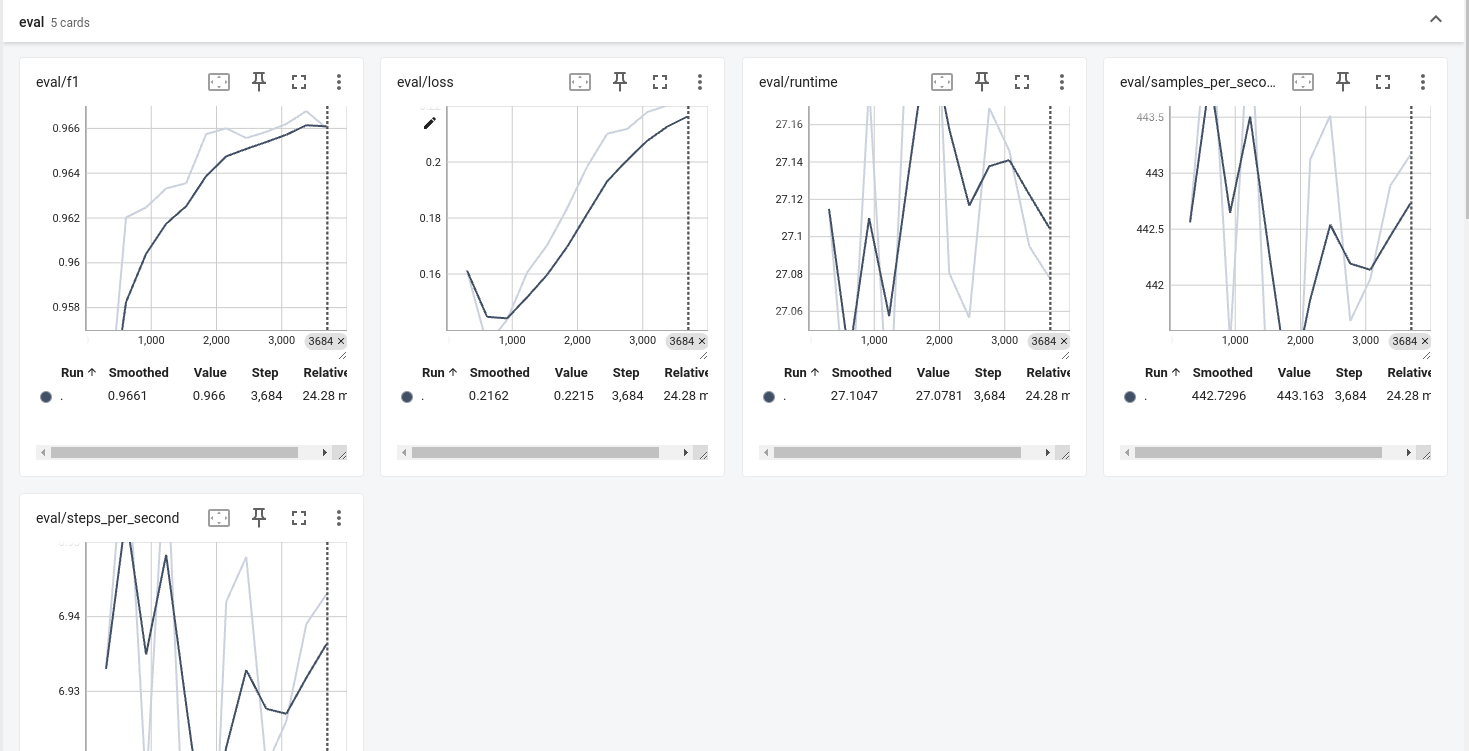

In [11]:

cm = Image.open('evals.png')
cm

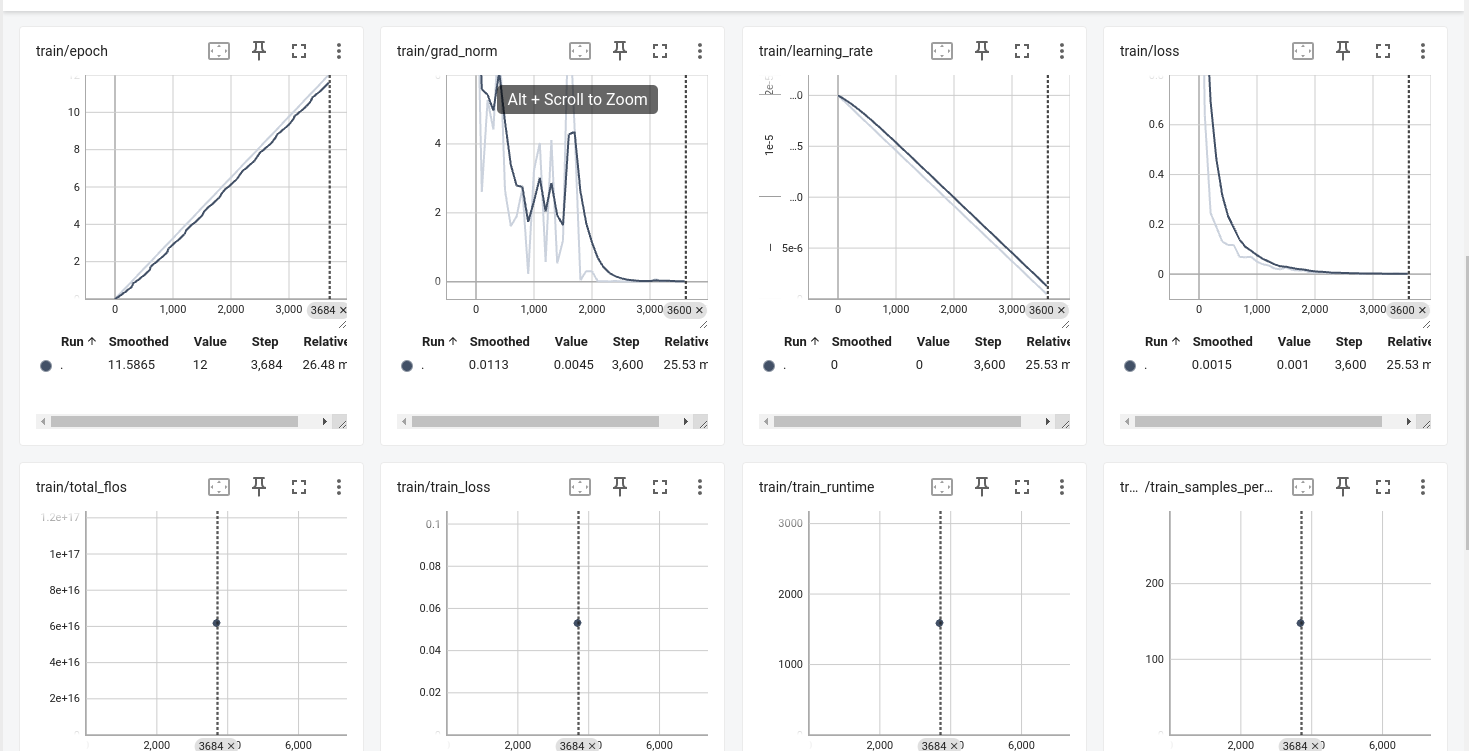

In [12]:

cm = Image.open('train.png')
cm

## Testing

In [2]:
import torch
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os

model_name = "allenai/scibert_scivocab_uncased"
checkpoint = 'scibert3/checkpoint-3684'

# Load the pretrained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

# Define Custom Dataset for Test Data
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Preprocessing function for text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

# Load dataset
def load_test_data(test_path):
    test_data = pd.read_csv(test_path)
    return test_data

# Preprocess data
def preprocess_test_dataset(test_data):
    test_data['Abstract'] = test_data['Abstract'].apply(preprocess_text)
    return test_data

# Prepare datasets
def prepare_test_dataset(test_data, tokenizer):
    X_test = test_data['Abstract'].values
    y_test = test_data['Y1'].values
    test_dataset = CustomDataset(X_test, y_test, tokenizer)
    return test_dataset, y_test

# Define the metrics computation function
def compute_metrics(predictions, labels):
    pred = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, pred, average='weighted')
    cm = confusion_matrix(labels, pred)
    return {'f1': f1, 'confusion_matrix': cm}

# Define confusion matrix plotting
def plot_confusion_matrix(cm, model_name, checkpoint, filename="confusion_matrix_test.png"):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {model_name} at {checkpoint}')
    
    # Save the plot in the current directory
    current_directory = os.getcwd()  # Get current working directory
    file_path = os.path.join(current_directory, filename)
    plt.savefig(file_path)  # Save the figure
    
    plt.close()  # Close the plot to free up memory
    print(f"Confusion matrix saved to {file_path}")

def test_model():
    # Load the pre-trained model
    model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=6)

    model.eval()  # Put model in evaluation mode

    # Load and preprocess test data
    test_data = load_test_data('data/test_data.csv')
    test_data = preprocess_test_dataset(test_data)

    # Prepare test dataset
    test_dataset, y_test = prepare_test_dataset(test_data, tokenizer)

    # Initialize Trainer
    trainer = Trainer(model=model)

    # Make predictions on test set
    predictions = trainer.predict(test_dataset)

    # Compute metrics
    metrics = compute_metrics(predictions.predictions, y_test)

    # Print F1-score
    print(f"F1-score: {metrics['f1']}")

    # Plot confusion matrix with model name and checkpoint
    plot_confusion_matrix(metrics['confusion_matrix'], model_name, checkpoint)

test_model()


/home/cesar/Projects/uprm-event-files-main-2024/uprm-event-files-main/.conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/cesar/Projects/uprm-event-files-main-2024/uprm-event-files-main/.conda/lib/python3.11/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
100%|██████████| 1050/1050 [00:20<00:00, 52.03it/s]

F1-score: 0.9648382232075617
Confusion matrix saved to /home/cesar/Projects/uprm-event-files-main-2024/uprm-event-files-main/confusion_matrix_test.png


# Confusion Matrix


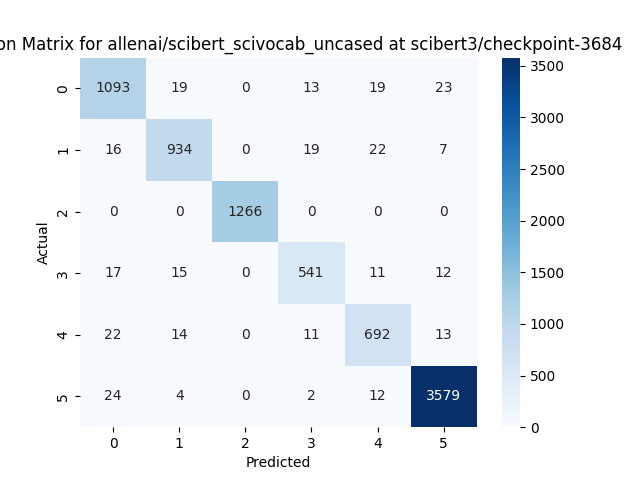

In [8]:
import PIL.Image

cm = Image.open('confusion_matrix_test.png')
cm

<!-- New line here... -->

## Submissions
Please email your submissions to hamzah.abdulrazzaq@lmco.com and stephen.palmier@lmco.com. All these items must be complete in order for your submission to be considered for evaluation. 
> 1. Email title set to *yourteamname_submission* 
> 2. The python notebook with all your code (.ipynb) 
> 3. F1 Score copied in with all the digits

Feel free to check out these resources to learn more about evaluation metrics used in Data Science: 
> - https://towardsdatascience.com/how-to-evaluate-machine-learning-model-performance-in-python-135b4ae27f7e 
> - F1 Score: https://towardsdatascience.com/how-to-evaluate-machine-learning-model-performance-in-python-135b4ae27f7e

## Evaluation Process
> - The submission deadline is on Sunday (9/8) 12PM
> - Participants are encouraged to submit as much as they can, and we will select the one with the highest F1 score too add to the leaderboard. 
> - Winners will be announced on Sunday (9/8) 2PM. We'll have a session for winning team to provide a walkthrough of their code, their strategies on how they approached the problem and engage in a discussion.  